## DETECTING TOXICITY ON SOCIAL MEDIA COMMENTS

## HYPOTHESIS : 
**TOXICITY ON ONLINE PLATFORMS CAN BE ACCURATELY DETECTED AND CLASSIFIED USING NATURAL LANGUAGE PROCESSING AND DEEP LEARNING TECHNIQUES**

## INSTRUCTIONS:
1. Installing the following libraries : scikit-multilearn, nltk, tensorflow, keras, scikit-learn, pandas, re, string, numpy, matplotlib, wordcloud 
2. Unzipping and loading the following documents: 
  - train.csv.zip
  - test.csv.zip
  - labels.csv.zip
  - glove.6B.zip (to be downloaded from : http://nlp.stanford.edu/data/glove.6B.zip )
3. Adjusting the path based on the location of these files
4. Running all the cells
5. Note : The LSTM and RNN models would take a long time to run since the dataset is very large

## METHODOLOGY : 
This notebook contains the following sections. 
1. DATA INGESTION
2. DATA PREPROCESSING
3. EXPLORATORY ANALYSIS AND VISUALIZATION
4. VECTORIZATION
5. CLASSIFICATION
  - BASELINE MODEL - MULTINOMIAL NAIVE BAYES CLASSIFIER
  - VANILLA RNN
  - LSTM 
6. EVALUATION
7. COMPARISON WITH CURRENT MODELS
8. CONCLUSION
9. REFERENCES

In [24]:
#Installing required package
!pip install scikit-multilearn

In [25]:
# Imports
import nltk
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import keras
import keras.utils
from tensorflow.keras import layers
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Embedding
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score

In [26]:
# Downloading punkt to remove punctuations
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Unzipping the train and test csv files

In [4]:
!unzip "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/train.csv.zip" -d "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/"

Archive:  /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/train.csv.zip
replace /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [37]:
!unzip "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test.csv.zip" -d "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/"

Archive:  /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test.csv  


In [47]:
!unzip "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip" -d "/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/"

Archive:  /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: /content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv  


## LOADING THE DATA

In [27]:
# Reading the training data
data = pd.read_csv(r"/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/train.csv")
data = data.drop('id', axis=1)
data

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
# Original comment (before cleaning)
data.comment_text[159566]

'":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can\'t even give a consistent argument - is the opening only supposed to mention significant aspects, or the ""most significant"" ones?   \n\n"'

## DATA PREPROCESSING

In [6]:
# Checking for NaN values
data.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [28]:
''' Function to clean the comments
Input : comments
Processing : Removing punctuation marks, lemmatizing, removing urls and other unnecessary characters and adding the cleaned comments to the dataframe
Output : Dataframe with cleaned comment_text column ''' # [10]

def data_cleaning(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    lower_text = text.lower()
    reg=re.sub(r"(\w+)'s", r'\1', lower_text)
    reg=reg.replace("'", "")
    reg=reg.replace("-"," ")
    reg = reg.replace('\n'," ")
    reg = reg.replace(':'," ")
    reg1=re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', reg) #removing url
    punc=str.maketrans(string.punctuation,32*" ")
    pt=reg1.translate(punc)
    return pt

# Applying the data_cleaning function on an entire dataframe column
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    p=[]
    for val in df['comment_text']:
        p.append(data_cleaning(val,lemmatizer))
    df['comment_text']=p
    return df

In [29]:
# Cleaned training dataframe
data_processed = process_all(data)
data_processed

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,daww he matches this background colour im see...,0,0,0,0,0,0
2,hey man im really not trying to edit war it ...,0,0,0,0,0,0
3,more i cant make any real suggestions on imp...,0,0,0,0,0,0
4,you sir are my hero any chance you remember...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,and for the second time of asking when ...,0,0,0,0,0,0
159567,you should be ashamed of yourself that is a ...,0,0,0,0,0,0
159568,spitzer umm theres no actual article for pr...,0,0,0,0,0,0
159569,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [32]:
# Cleaned comment
# As you can see all the puctuation marks, "\", ":", "\n" etc have been removed
data_processed.comment_text[159566]

'      and for the second time of asking  when your view completely contradicts the coverage in reliable sources  why should anyone care what you feel  you cant even give a consistent argument   is the opening only supposed to mention significant aspects  or the   most significant   ones       '

## EXPLORATORY ANALYSIS AND VISUALIZATIONS

In [17]:
# Correlation between each labels
correlation = data_processed.corr()
correlation

# The highest correlation exists between 'obscene' and 'toxic' columns

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [30]:
# Train - validation split
x = data_processed['comment_text']
x_train = x[:119679]
x_val = x[119679:]
y = data_processed[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y_train = y[:119679]
y_val = y[119679:]

In [31]:
# Multilabel Classification
# This cell shows how the labels can belong to any of the 6 classes. 
# Hence, this is a multi-label classification problem.
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
119674,0,0,0,0,0,0
119675,0,0,0,0,0,0
119676,0,0,0,0,0,0
119677,0,0,0,0,0,0


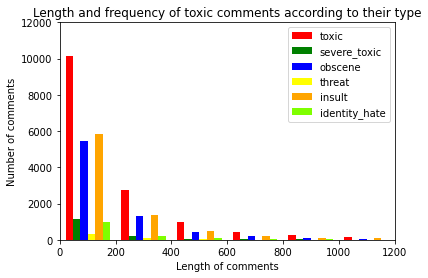

Number of non-toxic comments :  143663


In [13]:
# Visualization - Number of comments and the length of comments for each type of toxicity [9]
# [4]
not_toxic = 0
yi = np.zeros(y.shape)
for i in range(len(data['comment_text'])):
  l = len(data['comment_text'][i])

  if data['toxic'][i] == 1:
        yi[i][0] = l
  if data['severe_toxic'][i] == 1:
        yi[i][1] = l
  if data['insult'][i] == 1:
        yi[i][2] = l
  if data['threat'][i] == 1:
        yi[i][3] = l
  if data['obscene'][i] == 1:
        yi[i][4] = l
  if data['identity_hate'][i] == 1:
        yi[i][5] = l
  elif data['toxic'][i] == 0 and data['severe_toxic'][i]== 0 and data['insult'][i]==0 and data['identity_hate'][i]==0 and data['threat'][i]==0:
    not_toxic += 1
bins = [1, 200, 400, 600, 800, 1000, 1200]
labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(yi,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 12000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.title('Length and frequency of toxic comments according to their type')
plt.show()
print("Number of non-toxic comments : ", not_toxic)

## VECTORIZATION

CREATING WORD EMBEDDINGS USING THE GLOVE MODEL

In [33]:
# Unzipping the Glove model
!unzip "/content/drive/My Drive/NLP_Project/glove.6B.zip"

Archive:  /content/drive/My Drive/NLP_Project/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
# Loading Embeddings
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
          None 
    print("Done.",len(model)," words loaded!")
    return model

In [35]:
# Loading the glove model
glove_embeddings = loadGloveModel('glove.6B.300d.txt')

Loading Glove Model
Done. 400000  words loaded!


In [36]:
# One hot encoding the data
vocabulary = 20000
encoded_train = []
for x in x_train:
  e = one_hot(x, vocabulary, lower=False)
  encoded_train.append(e)
print(encoded_train[:10])

[[17403, 3000, 3685, 19791, 17023, 19384, 4292, 13635, 10695, 2918, 3648, 7152, 8216, 9007, 7904, 8107, 15902, 18886, 6589, 2816, 5551, 18799, 1441, 16184, 9752, 4513, 17233, 7285, 11920, 14213, 9465, 14282, 16702, 3685, 18479, 1881, 3685, 6157, 5852, 16454, 599, 8843, 12322, 19182, 3837, 8669, 6169], [4444, 13962, 5215, 7438, 11094, 4849, 599, 11865, 13088, 12415, 11213, 6157, 13074, 7890, 17296, 8110, 14400, 7307], [3601, 743, 599, 7561, 14780, 12609, 489, 2183, 13537, 7140, 15902, 9628, 7438, 10940, 5126, 14978, 7848, 10632, 9131, 14213, 5491, 489, 9329, 14475, 19791, 19958, 5756, 4292, 6157, 5852, 13962, 19490, 489, 9041, 981, 17705, 3685, 4084, 3699, 3685, 1871, 19641], [981, 1441, 18820, 9882, 11983, 19238, 2607, 6589, 3343, 1441, 5029, 12528, 3685, 8144, 1827, 6507, 6362, 10040, 6589, 453, 6763, 19689, 5756, 19437, 5756, 8285, 1441, 10744, 3685, 3517, 8034, 1673, 6427, 11675, 9628, 9007, 13317, 7904, 13280, 3685, 3342, 497, 12421, 18870, 7020, 12421, 11331, 1441, 13445, 5423, 96

In [37]:
# Creating vocabulary
tokens= set()
for x in x_train:
  for t in nltk.word_tokenize(x):
    tokens.add(t)
vocabulary_size = len(tokens) + 1
# Creating word to number dictionary
word_index = {}
counter = 1
for i in tokens:
  word_index[i] = counter
  counter += 1

In [38]:
# Encoding the data with word dictionary
def encode(l):
  encoded = []
  for x in l:
    encode_x = []
    for t in nltk.word_tokenize(x):
      try:
        encode_x.append(word_index[t])
      except:
        encode_x.append(0)
    encoded.append(encode_x)

  # Padding data to a max length of words
  # Max sequence length is 40
  max_length = 40
  padded_x = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded_x, max_length

In [39]:
# Calling the encoding function on training and validation data
padded_train, max_length = encode(x_train)
padded_val, max_length = encode(x_val)

In [40]:
# Creating a weight matrix for words in training data
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, i in word_index.items():
	embedding_vector = glove_embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

VISUALIZATION 2 : CREATING A WORDCLOUD TO SEE THE MOST FREQUENT WORDS IN COMMENTS

Text(0.5, 1.0, 'Most frequent words in the comments')

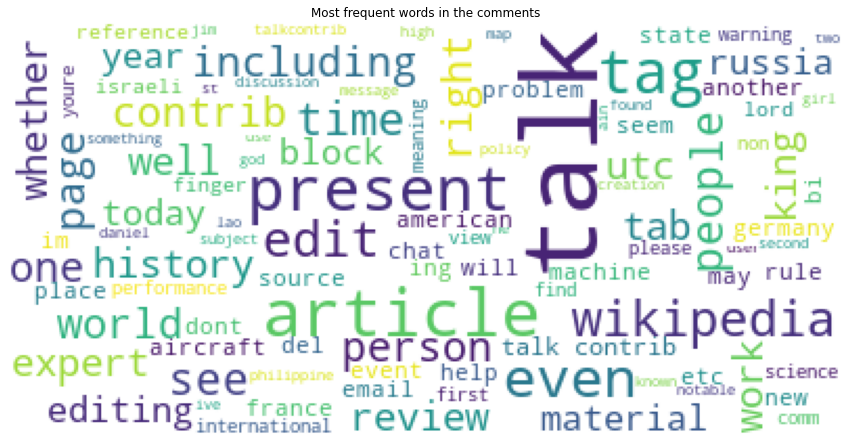

In [19]:
# Wordcloud of the most frequently occuring words in the comments
unique_string = " "
for t in tokens:
    unique_string += " " + t
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Most frequent words in the comments')

LOADING THE TEST DATA

In [41]:
#  Reading the test data 
test_data = pd.read_csv(r"/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test.csv")
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [42]:
# Reading the labels file
labels = pd.read_csv(r"/content/drive/My Drive/NLP_Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
labels

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


CLEANING THE TEST DATA

In [43]:
# Calling the data cleaning function on test data
test_processed = process_all(test_data)
test_processed = test_processed.drop('id', axis=1)

In [44]:
# Removing columns with label score "-1" to find evaluation values on test data
# Combining the comment and labels csv files to remove the incorrect rows
df = pd.concat([test_processed, labels], axis=1, sort=False)
df = df[df.toxic != -1]
df = df[df.severe_toxic != -1]
df = df[df.obscene != -1]
df = df[df.insult != -1]
df = df[df.identity_hate != -1]
df

,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,thank you for understanding i think very high...,0001ea8717f6de06,0,0,0,0,0,0
7,dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,somebody will invariably try to add relig...,0002f87b16116a7f,0,0,0,0,0,0
13,it says it right there that it is a type ...,0003e1cccfd5a40a,0,0,0,0,0,0
14,before adding a new product to the lis...,00059ace3e3e9a53,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,jerome i see you never got around to this… ...,fff8f64043129fa2,0,0,0,0,0,0
153151,lucky bastard http wikimediafoundation...,fff9d70fe0722906,0,0,0,0,0,0
153154,shame on you all you want to speak a...,fffa8a11c4378854,0,0,0,0,0,0
153155,mel gibson is a nazi bitch who makes shitty mo...,fffac2a094c8e0e2,1,0,1,0,1,0


In [45]:
# Creating embeddings of the test comments
x_test = df['comment_text']
padded_test, max_length = encode(x_test)
y_test = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

## CLASSIFYING COMMENTS BASED ON TOXICITY

BASELINE CLASSIFIER : 
Multinomial Naive Bayes

COMPLEX MODELS : 
1. Vanilla RNN
2. LSTM

MULTINOMIAL NAIVE BAYES

In [27]:
# Training the model

# Defining the model
nb_classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
# Fitting the model
nb_classifier.fit(padded_train, y_train)
# Predicting on training data to find the training accuracy
predictions = nb_classifier.predict(padded_train)

print("Train Accuracy : ", accuracy_score(y_train,predictions))

Train Accuracy :  0.539568345323741


In [28]:
# Predicting on validation data to find the training accuracy
predictions = nb_classifier.predict(padded_val)
print("Validation Accuracy : ", accuracy_score(y_val,predictions))

Validation Accuracy :  0.5316855509876667


In [29]:
# Predicting on test data to find the training accuracy
pred=nb_classifier.predict(padded_test)
print("Test accuacy : " , accuracy_score(y_test,pred))

Test accuacy :  0.5163337397230298


The Multinomial Naive Bayes classifier was chosen since it is a simple model and works as a good baseline for text data. The model is underfitting the data since both the train and test accuracies are low. Hence, there is a need to switch to a much more complex model.

VANILLA RNN

In [34]:
#Base model
model = Sequential()
# Adding an embedding layer
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim= 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
# Adding a dense layer
model.add(layers.SimpleRNN(300, activation='relu',recurrent_dropout=0.3,dropout=0.3))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarizing the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 300)           47972100  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 300)               180300    
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1806      
Total params: 48,154,206
Trainable params: 182,106
Non-trainable params: 47,972,100
_________________________________________________________________
None


In [35]:
# Saving the best model weights (with the least validation loss)
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/NLP_Project/rnn.h5', verbose=1, save_best_only=True)
# Fitting the data
m = model.fit(padded_train, y_train, batch_size = 32,callbacks = [checkpointer],epochs=50, validation_data=(padded_val,y_val))

Epoch 1/50
3740/3740 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.8546
Epoch 00001: val_loss improved from inf to 0.22627, saving model to /content/drive/My Drive/NLP_Project/rnn.h5
3740/3740 [==============================] - 94s 25ms/step - loss: 0.2293 - accuracy: 0.8546 - val_loss: 0.2263 - val_accuracy: 0.9727
Epoch 2/50
3739/3740 [============================>.] - ETA: 0s - loss: 0.2275 - accuracy: 0.8613
Epoch 00002: val_loss improved from 0.22627 to 0.22528, saving model to /content/drive/My Drive/NLP_Project/rnn.h5
3740/3740 [==============================] - 92s 25ms/step - loss: 0.2275 - accuracy: 0.8613 - val_loss: 0.2253 - val_accuracy: 0.9408
Epoch 3/50
3740/3740 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.8338
Epoch 00003: val_loss improved from 0.22528 to 0.22520, saving model to /content/drive/My Drive/NLP_Project/rnn.h5
3740/3740 [==============================] - 92s 25ms/step - loss: 0.2271 - accuracy: 0.8338 - 

In [33]:
# Loading the saved model
reconstructed_model = load_model('/content/drive/My Drive/NLP_Project/rnn.h5')
# Calucuating the accuracy and the loss of the best model on the training data
loss, accuracy = reconstructed_model.evaluate(padded_train, y_train, verbose=1)
print("Training accuracy: ", accuracy)
# Calucuating the accuracy and the loss of the best model on the validation data
loss, accuracy = reconstructed_model.evaluate(padded_val, y_val, verbose=1)
print('Validation accuracy: ' , accuracy)

3740/3740 [==============================] - 48s 13ms/step - loss: 0.2334 - accuracy: 0.9643
Training accuracy:  0.9643462896347046
1247/1247 [==============================] - 17s 13ms/step - loss: 0.2329 - accuracy: 0.9648
Validation accuracy:  0.9648300409317017


In [34]:
reconstructed_model = load_model('/content/drive/My Drive/NLP_Project/rnn.h5')
# Calucuating the accuracy and the loss of the best model on the test data
loss, accuracy = reconstructed_model.evaluate(padded_test, y_test, verbose=1)
print("Test accuracy: ", accuracy) 

2000/2000 [==============================] - 28s 14ms/step - loss: 0.2344 - accuracy: 0.9705
Test accuracy:  0.9704898595809937


The Vanilla RNN has solved the problem of underfitting, since it is much more complex than the Naive Bayes model. The model has a great accuracy due to the huge training corpus and right hyperparameter tuning

The ideal parameters for the Vanilla RNN model are : 
- Number number of hidden units = 300
- optimizer = adam
- Sequence length = 40
- Number of epochs = 50
- Recurrent_dropout=0.3
- Dropout=0.3

LSTM

In [84]:
model_lstm = keras.Sequential()
# Adding an embedding layer
model_lstm.add(layers.Embedding(input_dim=vocabulary_size, output_dim= 300, weights=[embedding_matrix], input_length=20, trainable=False))
model_lstm.add(layers.LSTM(64,recurrent_dropout=0.3,dropout=0.3))
# Adding a dense layer
model_lstm.add(Dense(6,activation = 'softmax'))
# Compiling the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Summarizing the model
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           47855400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 47,949,230
Trainable params: 93,830
Non-trainable params: 47,855,400
_________________________________________________________________


In [85]:
# Training the model
# Loading the saved model with the least validation loss
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/NLP_Project/lstm.h5', verbose=1, save_best_only=True)
# Fitting the data
m = model_lstm.fit(padded_train, y_train, batch_size = 32,callbacks = [checkpointer],epochs=50, validation_data=(padded_val,y_val))

Epoch 1/50
3740/3740 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.7861
Epoch 00001: val_loss improved from inf to 0.22203, saving model to /content/drive/My Drive/NLP_Project/lstm.h5
3740/3740 [==============================] - 286s 76ms/step - loss: 0.2246 - accuracy: 0.7861 - val_loss: 0.2220 - val_accuracy: 0.8061
Epoch 2/50
3740/3740 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.7830
Epoch 00002: val_loss improved from 0.22203 to 0.22134, saving model to /content/drive/My Drive/NLP_Project/lstm.h5
3740/3740 [==============================] - 293s 78ms/step - loss: 0.2218 - accuracy: 0.7830 - val_loss: 0.2213 - val_accuracy: 0.8659
Epoch 3/50
3740/3740 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.7562
Epoch 00003: val_loss improved from 0.22134 to 0.22086, saving model to /content/drive/My Drive/NLP_Project/lstm.h5
3740/3740 [==============================] - 294s 79ms/step - loss: 0.2208 - accuracy: 0.7

In [28]:
# Loading the saved model
final_model = load_model('/content/drive/My Drive/NLP_Project/lstm.h5')
# Calculating the accuracy and loss of the best model on the training data
loss, accuracy = final_model.evaluate(padded_train, y_train, verbose=1)
print('Training accuracy: ', accuracy)
# Calucuating the accuracy and the loss of the best model on the validation data
loss, accuracy = final_model.evaluate(padded_val, y_val, verbose=1)
print('Validation accuracy: ', accuracy)

3740/3740 [==============================] - 28s 7ms/step - loss: 0.2366 - accuracy: 0.9941
Training accuracy:  0.9940925240516663
1247/1247 [==============================] - 9s 7ms/step - loss: 0.2375 - accuracy: 0.9944
Validation accuracy:  0.9943848252296448


In [25]:
final_model = load_model('/content/drive/My Drive/NLP_Project/lstm.h5')
# Calucuating the accuracy and the loss of the best model on the test data
loss, accuracy = final_model.evaluate(padded_test, y_test, verbose=1)
print('Test accuracy', accuracy)

2000/2000 [==============================] - 14s 7ms/step - loss: 0.2386 - accuracy: 0.9976
Test accuracy 0.9976085424423218


The ideal parameters for the LSTM model are : 
- Number number of hidden units = 64
- optimizer = adam
- Sequence length = 20
- Number of epochs = 50
- Recurrent_dropout=0.3
- Dropout=0.3


## EVALUATION

BASELINE MODEL :
- Multinomial Naïve Bayes :
Training Accuracy =  53.9
Validation Accuracy = 53.1
Test Accuracy =  **51.6**

- Vanilla RNN :
Validation Accuracy = 96.48
Test Accuracy = **97.04**

- LSTM :
Validation Accuracy =  99.43
Test Accuracy = **99.76**
 

Hence, the LSTM model performs the best on the test data and has an accuracy of **0.997**

EXPERIMENTS CONDUCTED TO EVALUATE THE HYPOTHESIS : 
- Pre-processed the data using NLTK and Pandas functions
- Used a machine learning model - Multinomial Naive Bayes classifier to classify toxicity. The model underfitted on the data yielding an accuracy of just 51.6 %
- Trained two deep learning models - Vanilla RNN and LSTM for this NLP task and achieved an accuracy of 97.04 % and 99.76 %


**Thus, the hypothesis that deep learning models for NLP can detect and classify toxic comments on online platforms holds true.**

## COMPARISON 


| Comparison Parameters | Georgeakopoulos et al. [3] | Khieu et al. [4] | Chu et al. [5] | Kohli et al. [6] | Chakrabarty [11] |
| ------ | ------ | ------ | ------ | ------ | ------ |
| Methodology | Convolutional Neural Network | LSTM | CNN with character level-embeddings | LSTM with custom embeddings | tfidf with 6 headed machine learning |
| Mean Validation Accuracy | 91.2% | 92.7% | 94% | 97.78% | 98.08% |

## CONCLUSIONS 

- The models used in this task have obtained very high accuracy 
- Though the accuracy is higher than most of the models built by researchers, it is not the best metric to evaluate the models since the data has a high class imbalance, the non-toxic comments being 10 times higher in number than the other classes. The possible explanation behind such a high accuracy could be that the model is predicting non-toxic for all the classes. To improve this, the following measures can be taken : 
  1. Using a weighted loss function to take this into account
  2. Augmenting the classes with less data points
  3. Resampling the data to resolve class imbalance
  4. Using evaluation metrics that can take this into account like sensitivity, specificity, precision and F1 score
  This is the future work for this task

## REFERENCES

1. Coversation AI Team, https://conversationai.github.io/
2. https://www.easy-tensorflow.com/tf-tutorials/recurrent-neural-networks/vanilla-rnn-for-classification
3. Spiros V. Georgakopoulos, Sotiris K. Tasoulis, Aristidis G. Vrahatis and Vassilis P.
Plagianakos: ”Convolutional NeuralNetworksfor ToxicCommentClassification”,
10th Hellenic Conference on Artificial Intelligence, 2018.
4. Kevin Khieu and Neha Narwal: ”Detecting and Classifying Toxic Comments”,
https://web.stanford.edu/class/cs224n/reports/6837517.pdf
5. Theodora Chu, Kylie Jue and Max Wang: ”Comment Abuse Classification with Deep
Learning”, https://web.stanford.edu/class/cs224n/reports/2762092.pdf
6. ManavKohli, Emily Kuehler and John Palowitch: ”Paying attention to toxic comments online”, https://web.stanford.edu/class/cs224n/reports/6856482.pdf
7. https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
8. https://towardsdatascience.com/classifying-toxicity-in-online-comment-forums-end-to-end-project-57720af39d0b
9. https://github.com/nupurbaghel/Capstone_Project_ML
10. https://github.com/kasturijoshi06/Predicting-the-political-inclination-of-a-twitter-user/blob/master/political_inclination.ipynb
11. https://arxiv.org/ftp/arxiv/papers/1903/1903.06765.pdf
12. https://nlp.stanford.edu/projects/glove/